# PTB-XL ECG Dataset Preprocessing Source Code

Code to process the data from https://physionet.org/content/ptb-xl/1.0.1/

Download the PTB-XL dataset

In [2]:
from pathlib import Path

path = './ptb-xl/'
if not Path(path).exists():
    !wget -r -N -c -np https://physionet.org/files/ptb-xl/1.0.1/
    !mv physionet.org/files/ptb-xl/1.0.1 ptb-xl/
    !rm -rf physionet.org/

True

## Theory

### ECG Introduction
ECG is the abbreviated term for an electrocardiogram. It is used to record the electrical activity of the heart from different angles to both identify and locate pathology. Electrodes are placed on different parts of a patient’s limbs and chest to record the electrical activity.  



### ECG Electrode and Leads
An **ECG electrode** is a conductive pad that is attached to the skin to record electrical activity.   
An **ECG lead** is a graphical representation of the heart’s electrical activity which is calculated by analysing data from several ECG electrodes. Only 10 physical electrodes are attached to the patient, to generate the 12 leads. Each lead is meant to pick up electrical activity from a different position on the heart muscle.  
A 12-lead ECG records 12 leads, producing 12 separate graphs on a piece of ECG paper. **PTB-XL is a 12-lead ECG dataset**. 

#### ECG Leads
Chest leads  
- V1: septal view of the heart  
- V2: septal view of the heart  
- V3: anterior view of the heart
- V4: anterior view of the heart
- V5: lateral view of the heart
- V6: lateral view of the heart

Other leads  
- Lead I: lateral view (calculated by analysing activity between the RA and LA electrodes)
- Lead II: inferior view (calculated by analysing activity between the RA and LL electrodes)
- Lead III: inferior view (calculated by analysing activity between the LA and LL electrodes)
- aVR: lateral view (calculated by analysing activity between LA+LL -> RA)
- aVL: lateral view (calculated by analysing activity between RA+LL -> LA)
- aVF: inferior view (calculated by analysing activity between RA+LA -> LL)

### Sources
https://geekymedics.com/understanding-an-ecg/#:~:text=the%20right%20leg-,Leads,data%20from%20several%20ECG%20electrodes.

## Data Processing

In [1]:
import pandas as pd
import numpy as np
import wfdb
import ast
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [2]:

sampling_rate = 100

## Load and convert annotation data

In [3]:
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))
Y.head()

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,scp_codes,heart_axis,infarction_stadium1,infarction_stadium2,validated_by,second_opinion,initial_autogenerated_report,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,"{'NORM': 80.0, 'SBRAD': 0.0}",NaN,NaN,NaN,NaN,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,"{'NORM': 100.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,"{'NORM': 100.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,"{'NORM': 100.0, 'SR': 0.0}",NaN,NaN,NaN,NaN,False,False,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


In [4]:
Y.shape

(21837, 27)

## Load raw data

In [5]:
def load_raw_data(df, sr, path):
    if sr == 100:
        data = [wfdb.rdsamp(path + f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path + f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [6]:
X = load_raw_data(Y, sampling_rate, path)

The PTBXL dataset comprises 21837 clinical 12-lead ECG records of 10 seconds length from 18885 patients, where 52% were male and 48% were female.

In [7]:
X.shape

(21837, 1000, 12)

## Load `scp_statements.csv` for diagnostic aggregation

In [8]:
agg_df = pd.read_csv(path + 'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

In [9]:
agg_df.head()

,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
NDT,non-diagnostic T abnormalities,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,non-diagnostic T abnormalities,NaN,NaN,NaN,NaN
NST_,non-specific ST changes,1.0,1.0,NaN,STTC,NST_,Basic roots for coding ST-T changes and abnorm...,non-specific ST changes,145.0,MDC_ECG_RHY_STHILOST,NaN,NaN
DIG,digitalis-effect,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,suggests digitalis-effect,205.0,NaN,NaN,NaN
LNGQT,long QT-interval,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,long QT-interval,148.0,NaN,NaN,NaN
NORM,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,normal ECG,1.0,NaN,NaN,F-000B7


### Get the super-class for each `scp_code`

In [10]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [11]:
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

### Meaning of the superclasses:

**NORM**: Normal ECG  
**CD**  : Conduction Disturbance  
**MI**  : Myocardial Infarction  
**HYP** : Hypertrophy  
**STTC**: ST/T change

## Split data into train and test

In [12]:
test_fold = 10

In [13]:
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[(Y.strat_fold == test_fold)].diagnostic_superclass

In [14]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(19634, 1000, 12)
(19634,)
(2203, 1000, 12)
(2203,)


## Map superclasses to numbers in `y_test` and `y_train`

Remove entries without any super classes

In [15]:
y_test = y_test.to_numpy()
y_train = y_train.to_numpy()

In [16]:

def remove_empty(X, y):
    empty_indexes = []
    for i, v in enumerate(y):
        if len(v) == 0:
            empty_indexes.append(i)

    X = np.delete(X, empty_indexes, axis=0)
    y = np.delete(y, empty_indexes)
    
    return X, y

X_test, y_test = remove_empty(X_test, y_test)
X_train, y_train = remove_empty(X_train, y_train)

There are entries that belong to multiple classes, let's only get the first one

In [17]:
get_first_class = lambda t: t[0]
vfunc = np.vectorize(get_first_class)
y_test = vfunc(y_test)
y_train = vfunc(y_train)

Convert the classes to integers

In [18]:
def class_to_int(x):
    if x == 'NORM':
        return 0
    elif x == 'CD':
        return 1
    elif x == 'MI':
        return 2
    elif x == 'HYP':
        return 3
    elif x == 'STTC':
        return 4

y_test = np.array(list(map(class_to_int, y_test)))
y_train = np.array(list(map(class_to_int, y_train)))

In [19]:

print(X_train.shape, y_train.shape, '\n', X_test.shape, y_test.shape)

(19267, 1000, 12) (19267,) 
 (2163, 1000, 12) (2163,)


## Plot the data

We have 5 classes. Let's plot one sample for each class

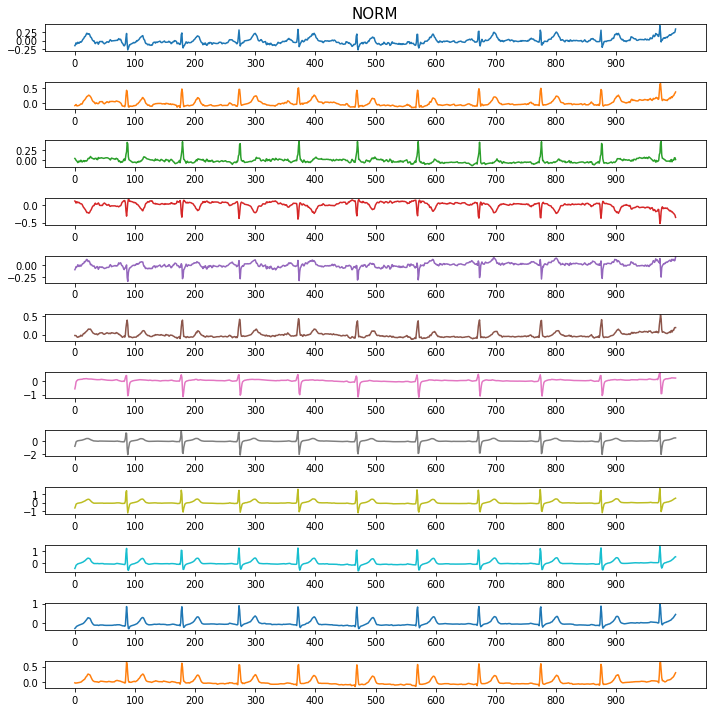

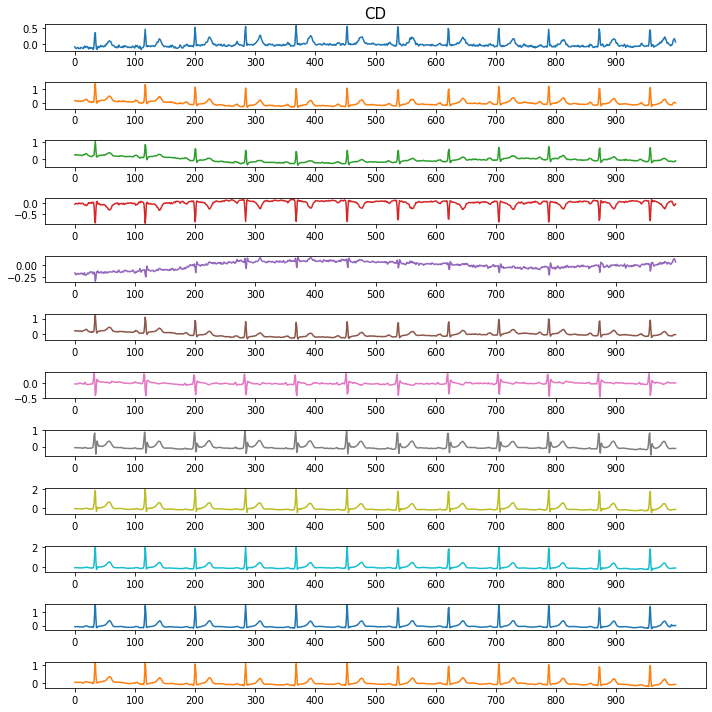

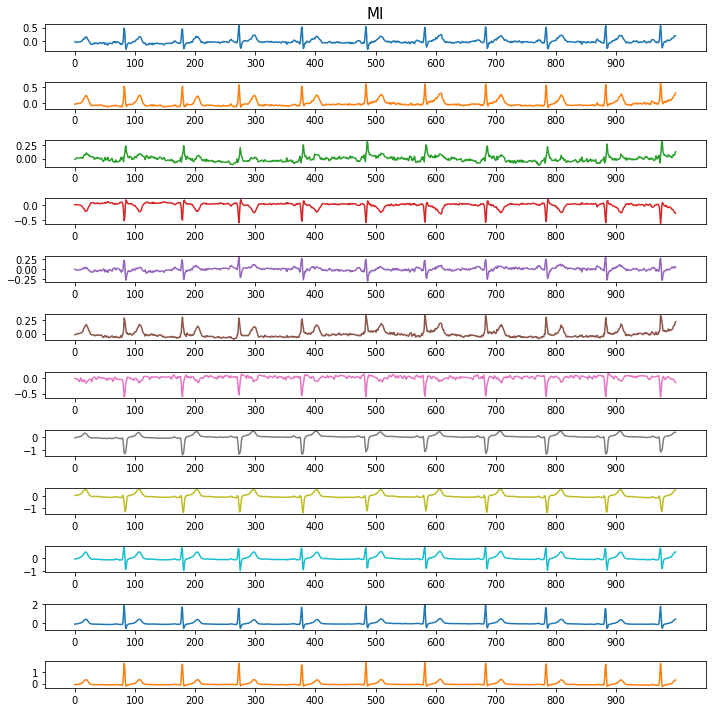

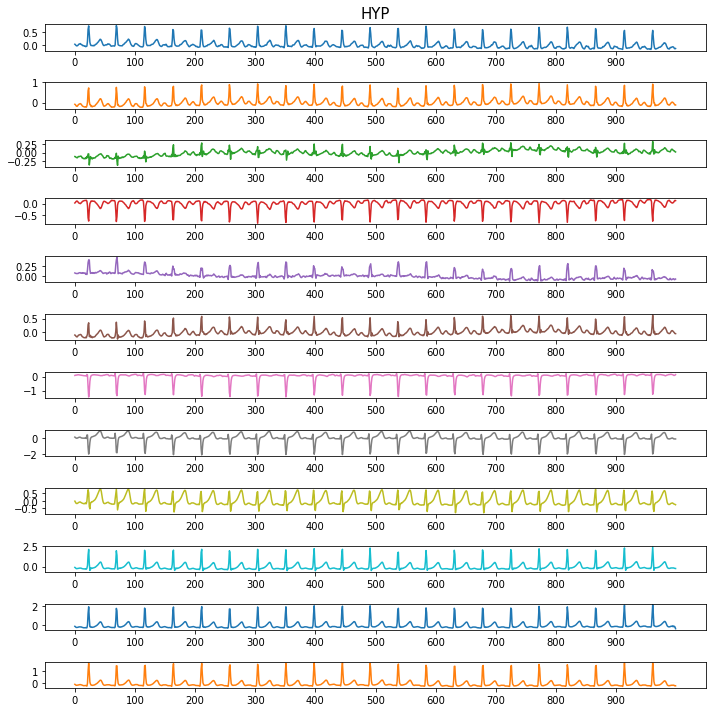

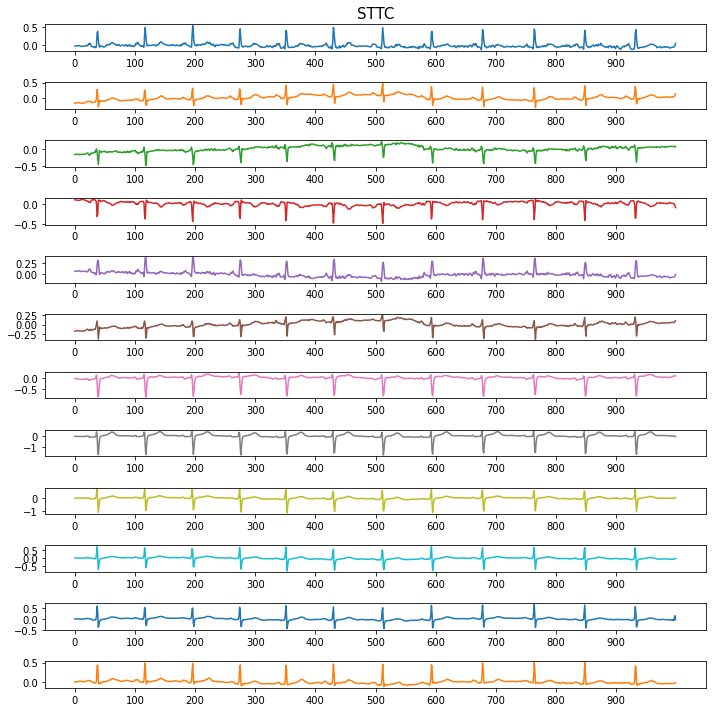

In [20]:
superclasses = {0: "NORM", 1: "CD", 2: "MI", 3: "HYP", 4: "STTC"}

for superclass in range(5):
    filt = y_test == superclass
    selected_index = np.where(filt)[0][0]
    y_selected = y_test[selected_index]
    x_selected = X_test[selected_index]
    
    fig, axes = plt.subplots(x_selected.shape[1], 1, figsize=(10,10))
    title = f"{superclasses[superclass]}"
    axes[0].set_title(title, fontsize=15)

    for i in range(x_selected.shape[1]):
        axes[i].plot(x_selected[:, i], color='C'+str(i))
        axes[i].set_xticks(np.arange(0, x_selected.shape[0], 100))
        # ax[i].set_yticks([0, 0.5, 1.0])
        
    plt.tight_layout()
    plt.show()

## Save the data into `.h5py` files

Reshape `X_train` and `X_test` before saving

In [24]:
X_train = np.transpose(X_train, (0, 2, 1))
X_test = np.transpose(X_test, (0, 2, 1))

(19267, 12, 1000)

In [26]:
import h5py

with h5py.File('ptbxl_train.hdf5', 'w') as hdf:
    hdf['X_train'] = X_train[:]
    hdf['y_train'] = y_train[:]
    print('Train data saved to ptbxl_train.hdf5')
with h5py.File('ptbxl_test.hdf5', 'w') as hdf:
    hdf['X_test'] = X_test[:]
    hdf['y_test'] = y_test[:]
    print('Test data saved to ptbxl_test.hdf5')

Train data saved to train_ptbxl.hdf5
Test data saved to test_ptbxl.hdf5


## References
Dataset: PTB-XL ver 1.0.1 (https://physionet.org/content/ptb-xl/1.0.1/)   
Some example code for data wrangling: https://www.kaggle.com/code/khyeh0719/ptb-xl-dataset-wrangling/notebook  